# LastFM Popularity

<b>What</b> are the most popular music genres in LastFM? <b>Who</b> are the most popular artists in each genre, and <b>where</b> do they come from? <br>
<b>When</b> the music was made? <b>What</b> are their mood?

These are the questions that these project makes. We will levarege the [dataset](https://www.kaggle.com/pieca111/music-artists-popularity) made available in Kaggle by [Piotr](https://www.kaggle.com/pieca111) to answer them.

### Lets take a look at the dataset.

In [119]:
import pandas as pd

df = pd.read_csv(
    'Datasets/artists.csv',
    dtype=dict(
        artist_lastfm=str, 
        country_lastfm=str, 
        tags_lastfm=str
        )
    )

df.head(1)

,mbid,artist_mb,artist_lastfm,country_mb,country_lastfm,tags_mb,tags_lastfm,listeners_lastfm,scrobbles_lastfm,ambiguous_artist
0,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,Coldplay,United Kingdom,United Kingdom,rock; pop; alternative rock; british; uk; brit...,rock; alternative; britpop; alternative rock; ...,5381567.0,360111850.0,False


To answer the questions we posed at the beginning, we will need:<br>
- <b>ambiguous_artist</b> | Sometimes more than one artist may share the same name
- <b>artist_lastfm</b> | Artist name in LastFM
- <b>country_lastfm</b> | Their countries
- <b>tags_lastfm</b> | Their tags
- <b>listeners_lastfm</b> | You get the idea.
- <b>scrobbles_lastfm</b>




In [120]:
df = df[['ambiguous_artist', 'artist_lastfm', 'country_lastfm', 'tags_lastfm', 'listeners_lastfm', 'scrobbles_lastfm']]
df.head()

,ambiguous_artist,artist_lastfm,country_lastfm,tags_lastfm,listeners_lastfm,scrobbles_lastfm
0,False,Coldplay,United Kingdom,rock; alternative; britpop; alternative rock; ...,5381567.0,360111850.0
1,False,Radiohead,United Kingdom,alternative; alternative rock; rock; indie; el...,4732528.0,499548797.0
2,False,Red Hot Chili Peppers,United States,rock; alternative rock; alternative; Funk Rock...,4620835.0,293784041.0
3,False,Rihanna,Barbados; United States,pop; rnb; female vocalists; dance; Hip-Hop; Ri...,4558193.0,199248986.0
4,False,Eminem,United States,rap; Hip-Hop; Eminem; hip hop; pop; american; ...,4517997.0,199507511.0


Way better.
### <b>However</b>

In [121]:
df.tail()

,ambiguous_artist,artist_lastfm,country_lastfm,tags_lastfm,listeners_lastfm,scrobbles_lastfm
1466078,False,NaN,South Korea,NaN,NaN,NaN
1466079,False,NaN,NaN,NaN,NaN,NaN
1466080,False,NaN,NaN,NaN,NaN,NaN
1466081,False,NaN,South Korea,NaN,NaN,NaN
1466082,False,NaN,South Korea,NaN,NaN,NaN


Looks like we have our fair share of null values

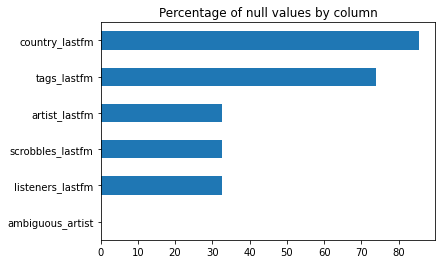

In [122]:
null_rate = (df.isna().sum() / len(df)) * 100

ax = (
    null_rate
    .sort_values()
    .plot.barh(title='Percentage of null values by column')
    )

The column with the highest number of null values is country_lastfm, with a <b>null rate of approximately 85%</b>. <br>

It might reasonable to assume that the artists with no country filled in their lastfm page should not be among the most popular. Lets drop all null values and check how many plays we lose

In [123]:
print('Total scrobbles (plays) before filtering null values:')
print(f'{df["scrobbles_lastfm"].sum():,}')

df.dropna(axis=0, how='any', inplace=True)

print('...and after:')
print(f'{df["scrobbles_lastfm"].sum():,}')

Total scrobbles (plays) before filtering null values:
120,324,972,038.0
...and after:
102,827,413,080.0


So we are losing less than 20% of the total plays by doing so.<br><br>
Now, lets see how much we lose by dropping the ambiguous artists

In [124]:
df.drop(df[df['ambiguous_artist']].index, inplace=True)
df.drop(df[df['scrobbles_lastfm'] <= 0].index, inplace=True) # lets drop artists with no plays as well

print('Total number of plays:' ,f'{df["scrobbles_lastfm"].sum():,}')
print('Total number of unique artists:' ,f'{len(df):,}')

Total number of plays: 87,214,810,301.0
Total number of unique artists: 171,128


So we are set with 3/4 of the original number of plays and with over 170 thousand unique artists. That will do. <br><br>
Some standard dataprep:

In [125]:
df.drop(['ambiguous_artist'], axis=1, inplace=True) # We don't need this column anymore
df.columns = ['artist', 'country', 'tags','listeners', 'scrobbles'] # If not at the sacrifice of clarity, shorter names = good
df[['scrobbles', 'listeners']] = df[['scrobbles', 'listeners']].astype(int) # There are no half listeners (nor half scrobble)
df.sort_values(by='scrobbles', ascending=False, inplace=True)

df.head()

,artist,country,tags,listeners,scrobbles
17,The Beatles,United Kingdom,classic rock; rock; british; 60s; pop,3674017,517126254
1,Radiohead,United Kingdom,alternative; alternative rock; rock; indie; el...,4732528,499548797
0,Coldplay,United Kingdom,rock; alternative; britpop; alternative rock; ...,5381567,360111850
8,Muse,United Kingdom,alternative rock; rock; alternative; Progressi...,4089612,344838631
23,Arctic Monkeys,United Kingdom,indie rock; indie; british; rock; alternative;...,3501680,332306552


### We could really use these tags, if only they were each in their own row....

In [126]:
df['tags'] = df['tags'].apply(lambda x: x.split('; '))
df['country'] = df['country'].apply(lambda x: x.split('; ')) # Some gorups have members from multiple countries

df = df.explode('tags')
df = df.explode('country')

df.reset_index(inplace=True, drop=True)
df.head()

,artist,country,tags,listeners,scrobbles
0,The Beatles,United Kingdom,classic rock,3674017,517126254
1,The Beatles,United Kingdom,rock,3674017,517126254
2,The Beatles,United Kingdom,british,3674017,517126254
3,The Beatles,United Kingdom,60s,3674017,517126254
4,The Beatles,United Kingdom,pop,3674017,517126254


### There you go.

In [132]:
tags = df.groupby(by='tags').size().sort_values(ascending=False)
print(f'{len(tags):,}')

323,038


We have <b>323,038</b> unique tags.

<b>Which is quite a lot.</b> <br>
<br>
We will start off by selecting the <b>top 300 tags</b> in terms of the number of times that they appear. This will give us something more manageable to work with.

In [133]:
top_tags = tags[:500].copy()
print(top_tags.index[:50])

Index(['seen live', 'rock', 'electronic', 'pop', 'All', 'indie', 'alternative',
       'female vocalists', 'under 2000 listeners', 'experimental', 'american',
       'folk', 'metal', 'punk', 'male vocalists', 'electronica', 'ambient',
       'spotify', 'USA', 'jazz', 'singer-songwriter', 'instrumental',
       'hardcore', '00s', 'dance', 'alternative rock', 'indie rock', 'german',
       'japanese', 'british', 'Hip-Hop', 'punk rock', '90s', 'psychedelic',
       'electro', 'world', '80s', 'chillout', 'death metal', 'acoustic',
       'french', 'black metal', 'rap', 'indie pop', 'female vocalist',
       'hard rock', 'hip hop', 'techno', 'heavy metal', 'soul'],
      dtype='object', name='tags')


In [187]:
from importlib import reload
import tag_flagger
reload(tag_flagger)
from tag_flagger import tag_flagger_machine

In [188]:
test = tag_flagger_machine(top_tags[:10].index)

female vocalists -> decade 
 --------------------        
 1 = genre        
 2 = mood        
 3 = decade        
 x = exit program        
 anything else = dump        
 -------------------- 
 Tag: under 2000 listeners
Program terminated.


In [137]:
top_tags[400:500].index

Index(['latino', 'Austria', 'singer songwriter', 'poetry', 'death',
       'groove metal', 'los angeles', 'the netherlands', 'industrial rock',
       'glam rock', 'prog', 'roots', 'gospel', 'powerpop', 'band', 'scotland',
       'electro-industrial', 'ska punk', 'Post-Industrial', 'goa', 'download',
       'electroacoustic', 'lovely', 'progressive death metal', 'orchestral',
       'Portugal', 'humor', 'opera', 'christian rock', 'Black',
       'Nu-Bluz Funky Grooves in the E-Lounge', 'instrumental hip-hop', 'deep',
       'remix', 'check', 'chill out', 'idol', 'Jazz Rock', 'Contemporary',
       'visual kei', 'humour', 'lute', 'chile', 'Scandinavian Girls',
       'Nu-metal', 'denmark', 'chanson francaise', '<3', 'cover', 'Grime',
       'great', 'dance-pop', '1990s', 'legend', 'soft', 'freepurp1e',
       'western classical music', 'synth-pop', 'Officially Shit', 'heavy',
       'america', 'want to see live', 'Acid', 'Gangsta Rap', 'balkan',
       'krautrock', 'Skinhead', 'best', '

### Warning! Arbitraty decisions below
I looked through the top 300 tags and manually classified them as one of the following:
- Musical genre
- Mood
- Decade

In [104]:
genres = [
    'rock', 'hip hop', 'post-punk', 'noise rock', 
    'Dance', 'hardcore punk',  'indie folk', 'r&b',
    'dark ambient', 'folk rock', 'lounge', 'rnb',
    'grindcore', 'doom metal', 'Psychedelic Rock',
    'post-hardcore', 'electropop', 'dub', 'shoegaze',
    'JPop', 'Disco', 'country', 'Brutal Death Metal',
    'Melodic Death Metal', 'Drum and bass', 'darkwave',
    'screamo', 'pop punk', 'hiphop', 'Power metal',
    'contemporary classical', 'dream pop', 'J-rock',
    'synth pop', 'Stoner Rock', 'Pop-Rock', 'Garage Rock',
    'Grunge', 'Gothic Rock', 'Sludge', 'acid jazz', 
    'metal', 'punk', 'ambient', 'jazz', 'death metal',
    'hardcore', 'alternative rock', 'indie rock',
    'Hip-Hop', 'punk rock', 'electro', 'chillout', 
    'black metal', 'rap', 'indie pop', 'hard rock', 
    'techno', 'heavy metal', 'soul', 'House', 'new age',
    'Progressive rock', 'industrial', 'new wave',
    'Classical', 'pop rock', 'Avant-Garde', 'downtempo',
    'blues', 'post-rock', 'trance', 'thrash metal', 
    'classic rock', 'synthpop', 'idm', 'j-pop',
    'metalcore', 'reggae', 'minimal', 'Fusion', 'ska',
    'trip-hop', 'Progressive metal', 'Lo-Fi',
    'Gothic Metal', 'blues rock', 'Experimental Rock',
    'glitch', 'melodic metal', 'Post punk', 'garage',
    'soft rock', 'britpop', 'breakbeat', 'power pop'
]

moods = [
    'Love', 'beautiful', 'sexy',
    'Mellow', 'groove', 'comedy',
    'funky', 'ethereal','melancholy', 
    'melancholic', 'romantic', 'fun',
    'relaxing', 'Dreamy'
]

decade = ['50s', '60s', '70s', '80s', '90s', '00s', '10s']


Lets keep only the tags that we selected by hand

In [105]:
tags_to_keep = genres + moods + decade
df.drop(df[~df['tags'].isin(tags_to_keep)].index, axis=0, inplace=True)

And flag each tag by their category (i.e. if it is a genre, a mood or a decade) so we can work with them separately

In [106]:
tags = [genres, moods, decade]
categories = ['genre', 'mood', 'decade']
tags_categories = dict()

for tag_group, category in zip(tags, categories):
    for tag in tag_group:
        tags_categories[tag] = category

df['tag_category'] = df['tags'].map(tags_categories)
df.head()

,artist,country,tags,listeners,scrobbles,tag_category
0,The Beatles,United Kingdom,classic rock,3674017,517126254,genre
1,The Beatles,United Kingdom,rock,3674017,517126254,genre
3,The Beatles,United Kingdom,60s,3674017,517126254,decade
6,Radiohead,United Kingdom,alternative rock,4732528,499548797,genre
7,Radiohead,United Kingdom,rock,4732528,499548797,genre


Some tags can be written in more than one way, such as melancholic and melancholy. Lets create a mapping between them and standarize our tags.

In [107]:
duplicate_tag_mapping = {
    'hip hop': 'Hip-Hop',
    'hiphop': 'Hip-Hop',
    'JPop': 'j-pop',
    'pop rock': 'Pop-Rock',
    'r&b': 'rnb',
    'synth pop': 'synthpop',
    'melancholic': 'melancholy'
}

df['tags'] = (df['tags'].map(duplicate_tag_mapping).fillna(df['tags']))
df.drop_duplicates(inplace=True)


### We need to be wary...<br> 
...of duplicating values when aggregating. <br>

Each artist appears in more than one row:

In [108]:
df.head(2)

,artist,country,tags,listeners,scrobbles,tag_category
0,The Beatles,United Kingdom,classic rock,3674017,517126254,genre
1,The Beatles,United Kingdom,rock,3674017,517126254,genre


So if we sum over an artist we end up multiplying its listeners and play count by the number of rows that it appears.

In [109]:
df.groupby('artist').sum().loc['The Beatles']

listeners    1.102205e+07
scrobbles    1.551379e+09
Name: The Beatles, dtype: float64

### We can handle that in Tableau... <br>
... by using aggregations such as "MAX". But that will require <b>Tableau to calculate it over and over again</b>.<br>
We can lend a hand to Tableau by creating boolean columns identifying unique rows.<br> <br>
We have increased the number of rows in our dataframe two times:

- When we expanded the <b>tags</b>
- and when we expanded the <b>countries</b>  <br>

We will start by creating a row count for each <b>artist</b> and each combination of <b>artist-tag</b> and <b>artist-country</b>

In [110]:
df['artist_unique'] =  df.groupby(['artist']).cumcount() + 1
df['tags_artist_unique'] = df.groupby(['artist', 'tags']).cumcount() + 1
df['country_artist_unique'] = df.groupby(['artist', 'country']).cumcount() + 1
df.head()

,artist,country,tags,listeners,scrobbles,tag_category,artist_unique,tags_artist_unique,country_artist_unique
0,The Beatles,United Kingdom,classic rock,3674017,517126254,genre,1,1,1
1,The Beatles,United Kingdom,rock,3674017,517126254,genre,2,1,2
3,The Beatles,United Kingdom,60s,3674017,517126254,decade,3,1,3
6,Radiohead,United Kingdom,alternative rock,4732528,499548797,genre,1,1,1
7,Radiohead,United Kingdom,rock,4732528,499548797,genre,2,1,2


And then flagging as <b>True</b> where the value is one

In [111]:
cols_to_bool = ['artist_unique', 'tags_artist_unique', 'country_artist_unique']

for col in cols_to_bool:
    df[col] = df[col].apply(lambda x: x==1)
    
df.head()

,artist,country,tags,listeners,scrobbles,tag_category,artist_unique,tags_artist_unique,country_artist_unique
0,The Beatles,United Kingdom,classic rock,3674017,517126254,genre,True,True,True
1,The Beatles,United Kingdom,rock,3674017,517126254,genre,False,True,False
3,The Beatles,United Kingdom,60s,3674017,517126254,decade,False,True,False
6,Radiohead,United Kingdom,alternative rock,4732528,499548797,genre,True,True,True
7,Radiohead,United Kingdom,rock,4732528,499548797,genre,False,True,False


### But...
We still have an issue to solve.<br>
Lets take a look at all the genres that we are currently assigning to <b>Radiohead<b/>

In [116]:
df[(df['artist']=='Adele') & (df['tag_category']=='genre')][['artist', 'tags']]

,artist,tags
1919,Adele,soul
1926,Adele,jazz
1931,Adele,britpop
1932,Adele,blues
1933,Adele,indie pop
1935,Adele,chillout
1938,Adele,rnb
1946,Adele,rock


# Need to explain here.

In [31]:
df_genres = df[df['tag_category'] == 'genre']
df['tag_order'] = df_genres.groupby('artist').cumcount() + 1
df['tag_order'] = df['tag_order'].fillna(1).astype(int)
df = df[df['tag_order'] < 4]


In [35]:
df.sort_values(by=['tags', 'scrobbles'], ascending=False, inplace=True)
df['artist_rank_by_tag'] = df.groupby(by=['tags'])['scrobbles'].rank(method='dense', ascending=False).astype(int)

<AxesSubplot:xlabel='listeners', ylabel='scrobbles'>

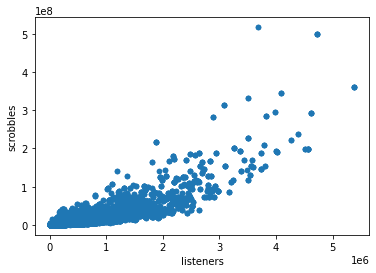

In [50]:
df.plot.scatter(x='listeners', y='scrobbles')

In [39]:
df['tags'] = df['tags'].str.capitalize()

In [478]:

df.to_csv('Datasets/lastfm_tags.csv', index=False)
##df.to_csv('Datasets/lastfm_artists.csv', index=False)

In [235]:
df[(df['artist']=='Radiohead') & (df['tag_category'] == 'mood')].head(20)

,artist,country,tags,listeners,scrobbles,tag_category,artist_unique,tags_artist_unique,country_artist_unique
28,Radiohead,United Kingdom,Melancholy,4732528,499548797,mood,False,True,False
35,Radiohead,United Kingdom,Beautiful,4732528,499548797,mood,False,True,False
